In [57]:
# Chroma Change Embeddings Analysis
# Analysis of extracted embeddings from chroma_change dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


In [58]:
# Load embeddings and metadata
embeddings_dir = Path("embeddings/chroma_change")
dataset_manifest_path = Path("local_experiments/color_dataset/chroma_change/manifest.json")

# Load dataset manifest for color information
with open(dataset_manifest_path, 'r') as f:
    dataset_manifest = json.load(f)

# Create mapping from index to color metadata
index_to_color = {}
for chain in dataset_manifest['chains']:
    for item in chain['items']:
        idx = str(item['index'])
        index_to_color[idx] = {
            'notation': item['notation'],
            'xyY': item['xyY'],
            'H': item['H'],
            'C': item['C'],
            'V': item['V'],
            'chain_description': chain['description']
        }

print(f"Loaded metadata for {len(index_to_color)} color samples")
print("Sample color data:")
for i in range(1, 6):
    if str(i) in index_to_color:
        print(f"  {i}: {index_to_color[str(i)]['notation']} - {index_to_color[str(i)]['chain_description']}")


Loaded metadata for 32 color samples
Sample color data:
  1: N0 - chain fixed H=N C=0 V=None
  2: N1 - chain fixed H=N C=0 V=None
  3: 2.5R 5/0 - chain fixed H=2.5R C=None V=5
  4: 2.5R 5/2 - chain fixed H=2.5R C=None V=5
  5: 2.5R 5/4 - chain fixed H=2.5R C=None V=5


In [59]:
# Load all embeddings
def load_embeddings(embeddings_dir):
    """Load all embedding files and return organized data"""
    embeddings_data = {
        'lm_pooled_mean': [],
        'vision_pooled_mean': [],
        'visual_token_lens': [],
        'indices': [],
        'metadata': []
    }
    
    # Get all subdirectories (numbered folders)
    subdirs = sorted([d for d in embeddings_dir.iterdir() if d.is_dir() and d.name.isdigit()])
    
    for subdir in subdirs:
        idx = subdir.name
        
        # Load manifest for metadata
        manifest_path = subdir / 'manifest.json'
        if manifest_path.exists():
            with open(manifest_path, 'r') as f:
                manifest = json.load(f)
            embeddings_data['metadata'].append(manifest)
        else:
            embeddings_data['metadata'].append({})
        
        # Load embeddings
        lm_path = subdir / 'lm_pooled_mean.npy'
        vision_path = subdir / 'vision_pooled_mean.npy'
        lens_path = subdir / 'visual_token_lens.npy'
        
        if lm_path.exists():
            lm_emb = np.load(lm_path)
            embeddings_data['lm_pooled_mean'].append(lm_emb.flatten())
        else:
            embeddings_data['lm_pooled_mean'].append(None)
            
        if vision_path.exists():
            vision_emb = np.load(vision_path)
            embeddings_data['vision_pooled_mean'].append(vision_emb.flatten())
        else:
            embeddings_data['vision_pooled_mean'].append(None)
            
        if lens_path.exists():
            lens_emb = np.load(lens_path)
            embeddings_data['visual_token_lens'].append(lens_emb.flatten())
        else:
            embeddings_data['visual_token_lens'].append(None)
            
        embeddings_data['indices'].append(idx)
    
    return embeddings_data

# Load the data
embeddings_data = load_embeddings(embeddings_dir)
print(f"Loaded embeddings for {len(embeddings_data['indices'])} samples")

# Check embedding shapes
for emb_type in ['lm_pooled_mean', 'vision_pooled_mean', 'visual_token_lens']:
    valid_embs = [emb for emb in embeddings_data[emb_type] if emb is not None]
    if valid_embs:
        print(f"{emb_type}: {len(valid_embs)} samples, shape {valid_embs[0].shape}")
    else:
        print(f"{emb_type}: No valid embeddings found")


Loaded embeddings for 32 samples
lm_pooled_mean: 32 samples, shape (3584,)
vision_pooled_mean: 32 samples, shape (3584,)
visual_token_lens: 32 samples, shape (1,)


In [60]:
# Prepare data for analysis
def prepare_embedding_matrix(embeddings_list):
    """Convert list of embeddings to matrix, filtering out None values"""
    valid_embeddings = [emb for emb in embeddings_list if emb is not None]
    if not valid_embeddings:
        return None, []
    
    # Get valid indices
    valid_indices = [i for i, emb in enumerate(embeddings_list) if emb is not None]
    
    # Stack embeddings into matrix
    embedding_matrix = np.vstack(valid_embeddings)
    return embedding_matrix, valid_indices

# Prepare matrices for each embedding type
lm_matrix, lm_valid_indices = prepare_embedding_matrix(embeddings_data['lm_pooled_mean'])
vision_matrix, vision_valid_indices = prepare_embedding_matrix(embeddings_data['vision_pooled_mean'])
lens_matrix, lens_valid_indices = prepare_embedding_matrix(embeddings_data['visual_token_lens'])

print("Embedding matrices prepared:")
if lm_matrix is not None:
    print(f"  LM pooled mean: {lm_matrix.shape}")
if vision_matrix is not None:
    print(f"  Vision pooled mean: {vision_matrix.shape}")
if lens_matrix is not None:
    print(f"  Visual token lens: {lens_matrix.shape}")

# Create color metadata for valid samples
def get_color_metadata(valid_indices, embeddings_data, index_to_color):
    """Get color metadata for valid embedding samples"""
    color_metadata = []
    for i, orig_idx in enumerate(valid_indices):
        idx = embeddings_data['indices'][orig_idx]
        if idx in index_to_color:
            color_info = index_to_color[idx].copy()
            color_info['original_index'] = orig_idx
            color_info['embedding_index'] = i
            color_metadata.append(color_info)
        else:
            color_metadata.append({
                'notation': f'Unknown_{idx}',
                'original_index': orig_idx,
                'embedding_index': i
            })
    return color_metadata

lm_color_meta = get_color_metadata(lm_valid_indices, embeddings_data, index_to_color)
vision_color_meta = get_color_metadata(vision_valid_indices, embeddings_data, index_to_color)
lens_color_meta = get_color_metadata(lens_valid_indices, embeddings_data, index_to_color)


Embedding matrices prepared:
  LM pooled mean: (32, 3584)
  Vision pooled mean: (32, 3584)
  Visual token lens: (32, 1)


In [61]:
# PCA Analysis for all embedding types
def perform_pca_analysis(embedding_matrix, color_metadata, embedding_name):
    """Perform PCA analysis and return results"""
    if embedding_matrix is None:
        print(f"No data available for {embedding_name}")
        return None
    
    # Standardize the data
    scaler = StandardScaler()
    embedding_matrix_scaled = scaler.fit_transform(embedding_matrix)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(embedding_matrix_scaled)
    
    # Calculate explained variance ratios
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Find number of components for different variance thresholds
    n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
    
    print(f"\n=== PCA Analysis for {embedding_name} ===")
    print(f"Original dimensions: {embedding_matrix.shape[1]}")
    print(f"Number of samples: {embedding_matrix.shape[0]}")
    print(f"Components for 90% variance: {n_components_90}")
    print(f"Components for 95% variance: {n_components_95}")
    print(f"Components for 99% variance: {n_components_99}")
    print(f"First 10 components explain {cumulative_variance[9]:.3f} of variance")
    
    return {
        'pca_result': pca_result,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance': cumulative_variance,
        'n_components_95': n_components_95,
        'n_components_99': n_components_99,
        'pca_model': pca,
        'scaler': scaler
    }

# Perform PCA for each embedding type
pca_results = {}
if lm_matrix is not None:
    pca_results['lm'] = perform_pca_analysis(lm_matrix, lm_color_meta, "LM Pooled Mean")
if vision_matrix is not None:
    pca_results['vision'] = perform_pca_analysis(vision_matrix, vision_color_meta, "Vision Pooled Mean")



=== PCA Analysis for LM Pooled Mean ===
Original dimensions: 3584
Number of samples: 32
Components for 90% variance: 5
Components for 95% variance: 7
Components for 99% variance: 11
First 10 components explain 0.986 of variance

=== PCA Analysis for Vision Pooled Mean ===
Original dimensions: 3584
Number of samples: 32
Components for 90% variance: 5
Components for 95% variance: 7
Components for 99% variance: 10
First 10 components explain 0.991 of variance


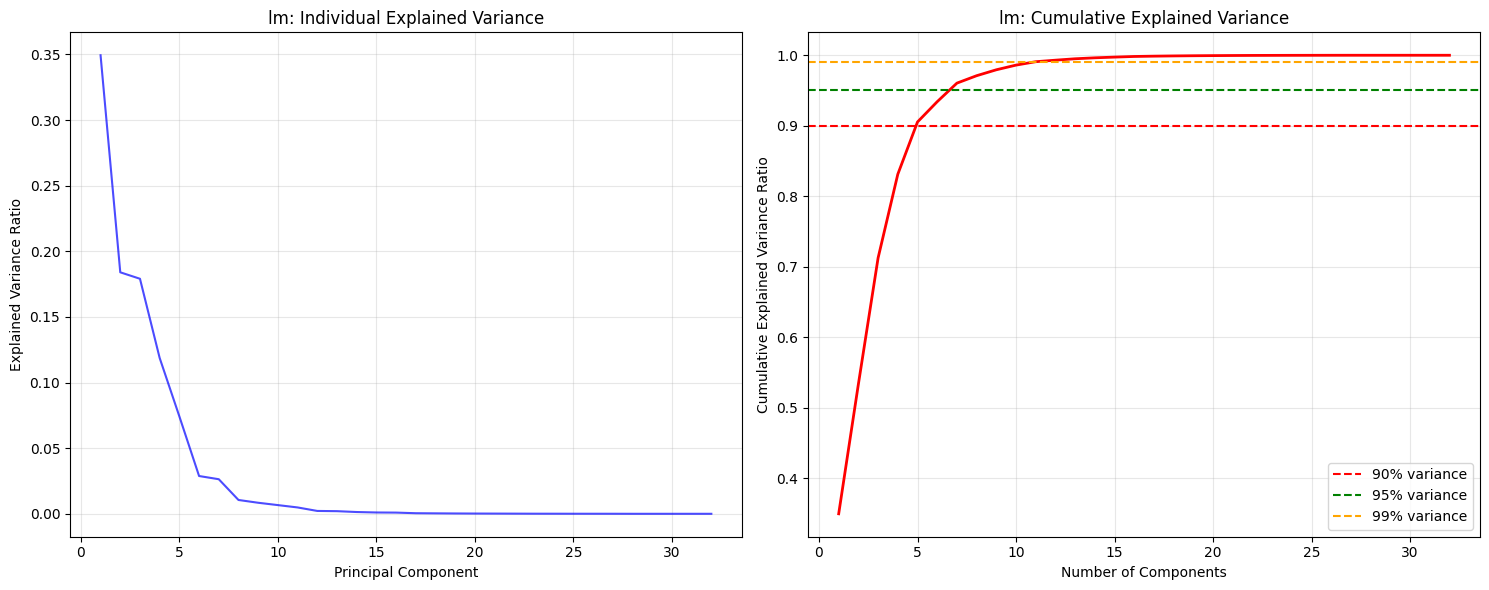

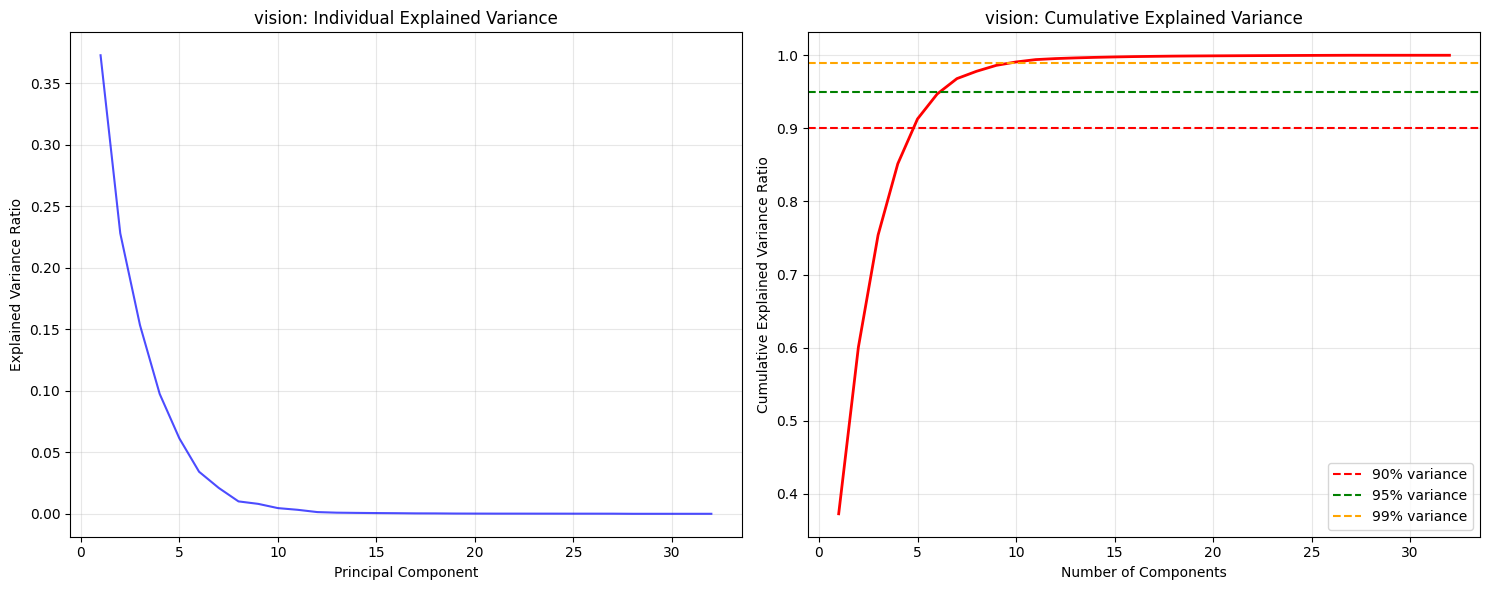

In [13]:

# Visualize PCA results
def plot_pca_variance(pca_results, embedding_name):
    """Plot explained variance for PCA"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    result = pca_results[embedding_name]
    explained_var = result['explained_variance_ratio']
    cumulative_var = result['cumulative_variance']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Individual explained variance
    ax1.plot(range(1, min(51, len(explained_var) + 1)), explained_var[:50], 'b-', alpha=0.7)
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title(f'{embedding_name}: Individual Explained Variance')
    ax1.grid(True, alpha=0.3)
    
    # Cumulative explained variance
    ax2.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'r-', linewidth=2)
    ax2.axhline(y=0.90, color='red', linestyle='--', label='90% variance')
    ax2.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
    ax2.axhline(y=0.99, color='orange', linestyle='--', label='99% variance')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title(f'{embedding_name}: Cumulative Explained Variance')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot PCA variance for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        plot_pca_variance(pca_results, emb_type)


In [71]:
# t-SNE Analysis for all embedding types
def perform_tsne_analysis(embedding_matrix, color_metadata, embedding_name, perplexity=7, n_iter=5000):
    """Perform t-SNE analysis and return results"""
    if embedding_matrix is None:
        print(f"No data available for {embedding_name}")
        return None
    
    print(f"\n=== t-SNE Analysis for {embedding_name} ===")
    print(f"Input shape: {embedding_matrix.shape}")
    print(f"Perplexity: {perplexity}")
    
    # Standardize the data
    scaler = StandardScaler()
    embedding_matrix_scaled = scaler.fit_transform(embedding_matrix)
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=n_iter, random_state=42, verbose=1, min_grad_norm=1e-8, n_iter_without_progress=1000)
    tsne_result = tsne.fit_transform(embedding_matrix_scaled)
    
    print(f"t-SNE completed. Final KL divergence: {tsne.kl_divergence_:.3f}")
    
    return {
        'tsne_result': tsne_result,
        'tsne_model': tsne,
        'scaler': scaler
    }

# Perform t-SNE for each embedding type
tsne_results = {}
if lm_matrix is not None:
    tsne_results['lm'] = perform_tsne_analysis(lm_matrix, lm_color_meta, "LM Pooled Mean")
if vision_matrix is not None:
    tsne_results['vision'] = perform_tsne_analysis(vision_matrix, vision_color_meta, "Vision Pooled Mean")



=== t-SNE Analysis for LM Pooled Mean ===
Input shape: (32, 3584)
Perplexity: 7
[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 33.724272


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.176132
[t-SNE] KL divergence after 5000 iterations: 0.108445
t-SNE completed. Final KL divergence: 0.108

=== t-SNE Analysis for Vision Pooled Mean ===
Input shape: (32, 3584)
Perplexity: 7
[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 34.178611
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.661354
[t-SNE] KL divergence after 2550 iterations: 0.167894
t-SNE completed. Final KL divergence: 0.168


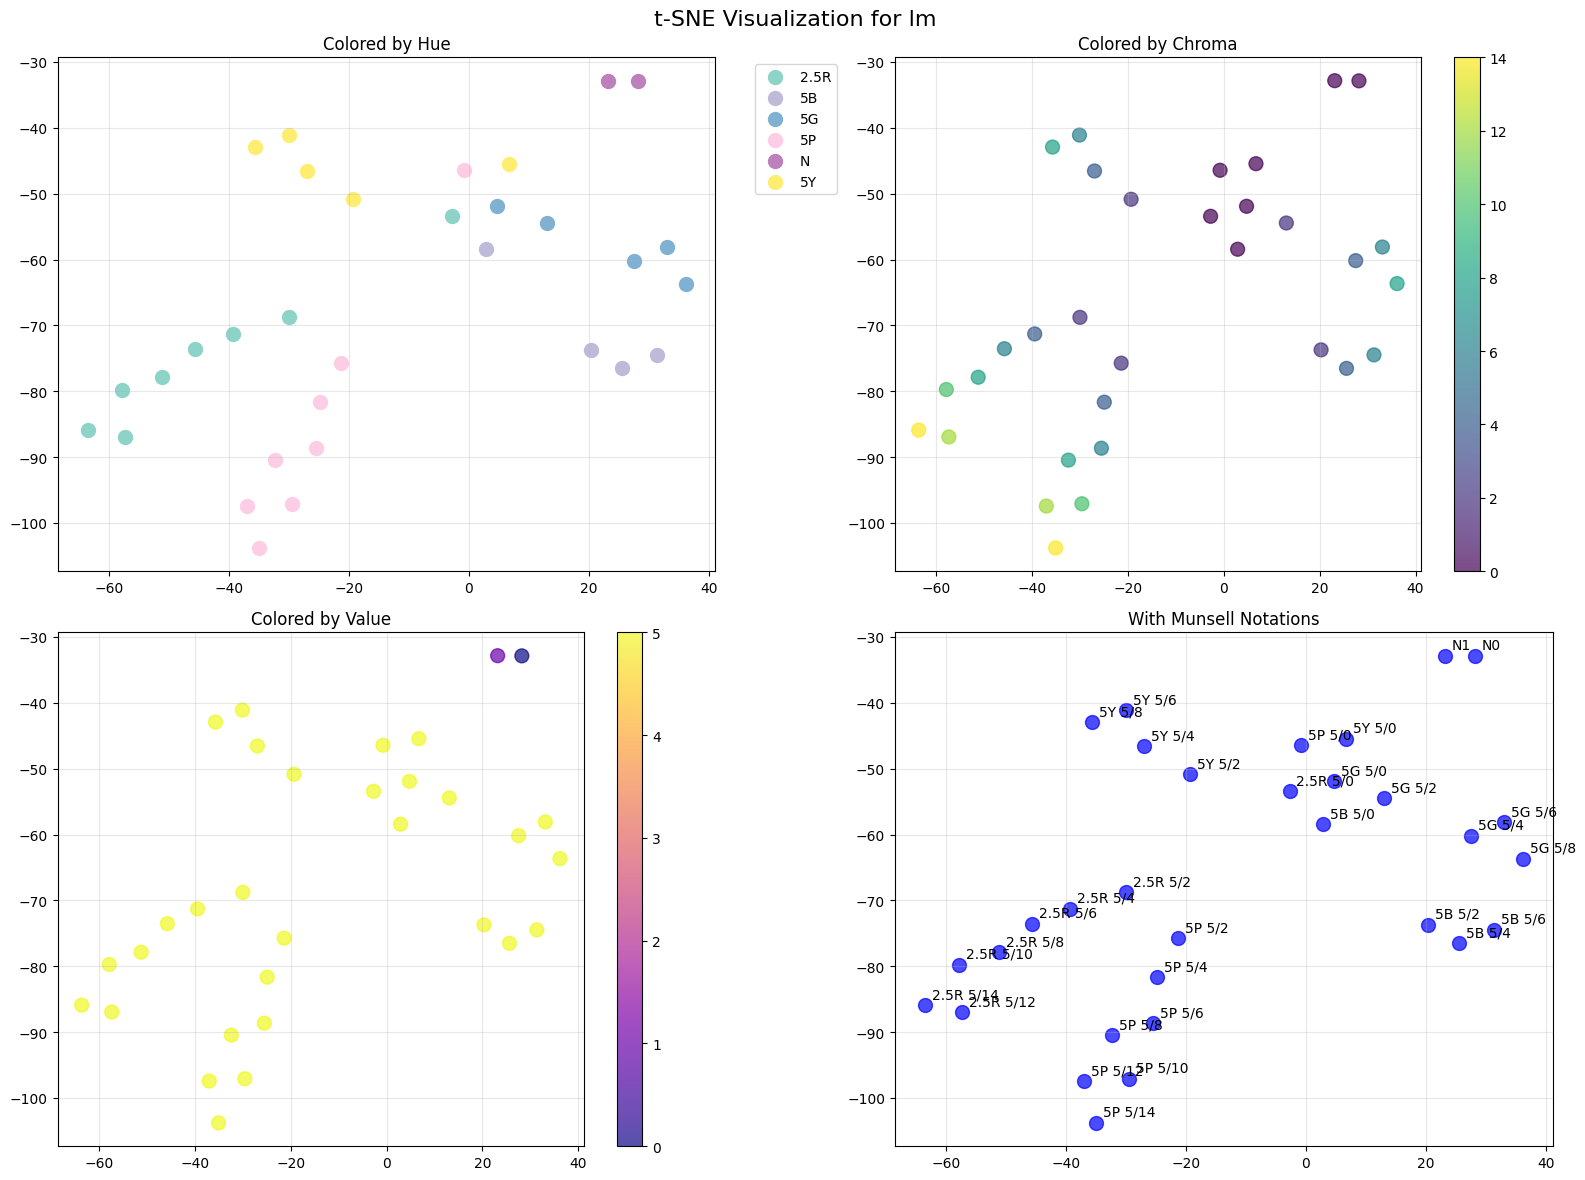

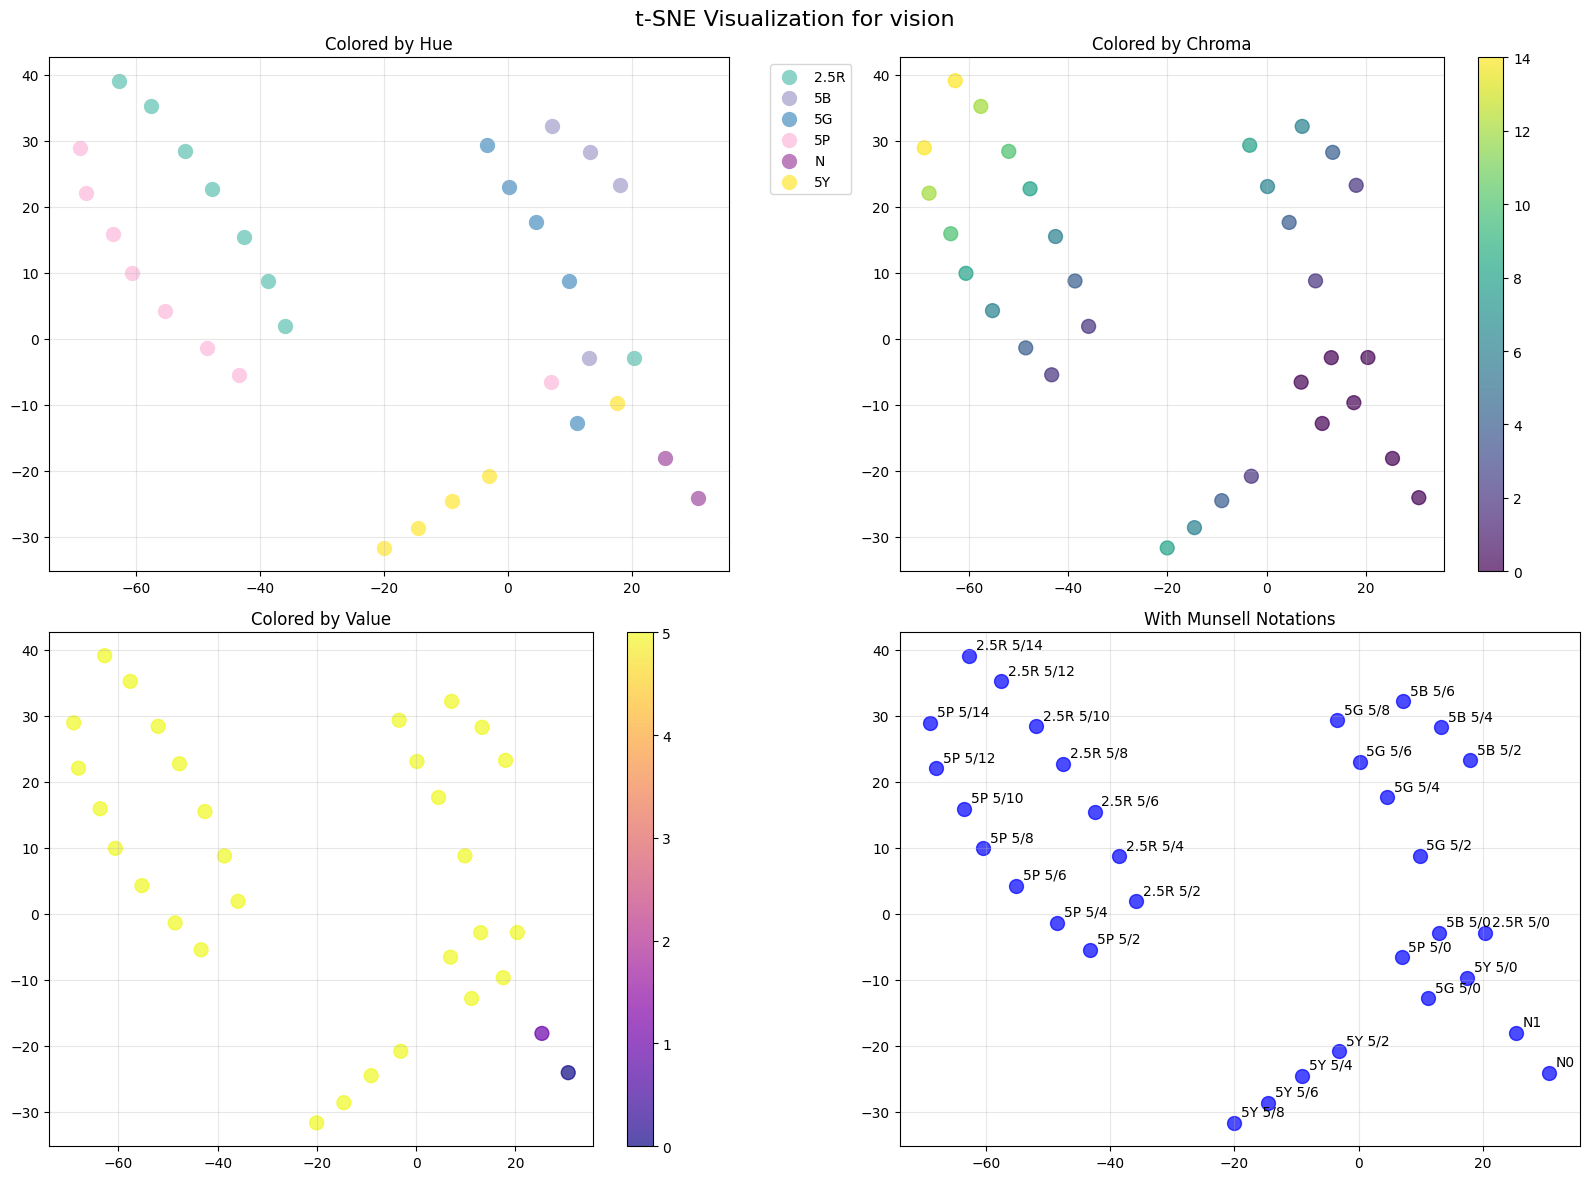

In [72]:
# Visualize t-SNE results with color information
def plot_tsne_results(tsne_results, color_metadata, embedding_name):
    """Plot t-SNE results colored by different color attributes"""
    if embedding_name not in tsne_results or tsne_results[embedding_name] is None:
        return
    
    tsne_result = tsne_results[embedding_name]['tsne_result']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f't-SNE Visualization for {embedding_name}', fontsize=16)
    
    # Extract color information
    hues = [meta.get('H', 'Unknown') for meta in color_metadata]
    chromas = [meta.get('C', 0) for meta in color_metadata]
    values = [meta.get('V', 0) for meta in color_metadata]
    notations = [meta.get('notation', 'Unknown') for meta in color_metadata]
    
    # Plot 1: Colored by Hue
    unique_hues = list(set(hues))
    hue_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: hue_colors[i] for i, hue in enumerate(unique_hues)}
    
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        axes[0,0].scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                         c=[hue_color_map[hue]], label=hue, alpha=1, s=100)
    axes[0,0].set_title('Colored by Hue')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Colored by Chroma
    scatter = axes[0,1].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                               c=chromas, cmap='viridis', alpha=0.7, s=100)
    axes[0,1].set_title('Colored by Chroma')
    plt.colorbar(scatter, ax=axes[0,1])
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Colored by Value
    scatter = axes[1,0].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                               c=values, cmap='plasma', alpha=0.7, s=100)
    axes[1,0].set_title('Colored by Value')
    plt.colorbar(scatter, ax=axes[1,0])
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: All points with notation labels
    axes[1,1].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                     c='blue', alpha=0.7, s=100)
    # Add notation labels
    for i, notation in enumerate(notations):
        axes[1,1].annotate(notation, (tsne_result[i, 0], tsne_result[i, 1]), 
                          xytext=(5, 5), textcoords='offset points', fontsize=10)
    axes[1,1].set_title('With Munsell Notations')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot t-SNE results for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in tsne_results:
        color_meta = {'lm': lm_color_meta, 'vision': vision_color_meta, 'lens': lens_color_meta}[emb_type]
        plot_tsne_results(tsne_results, color_meta, emb_type)


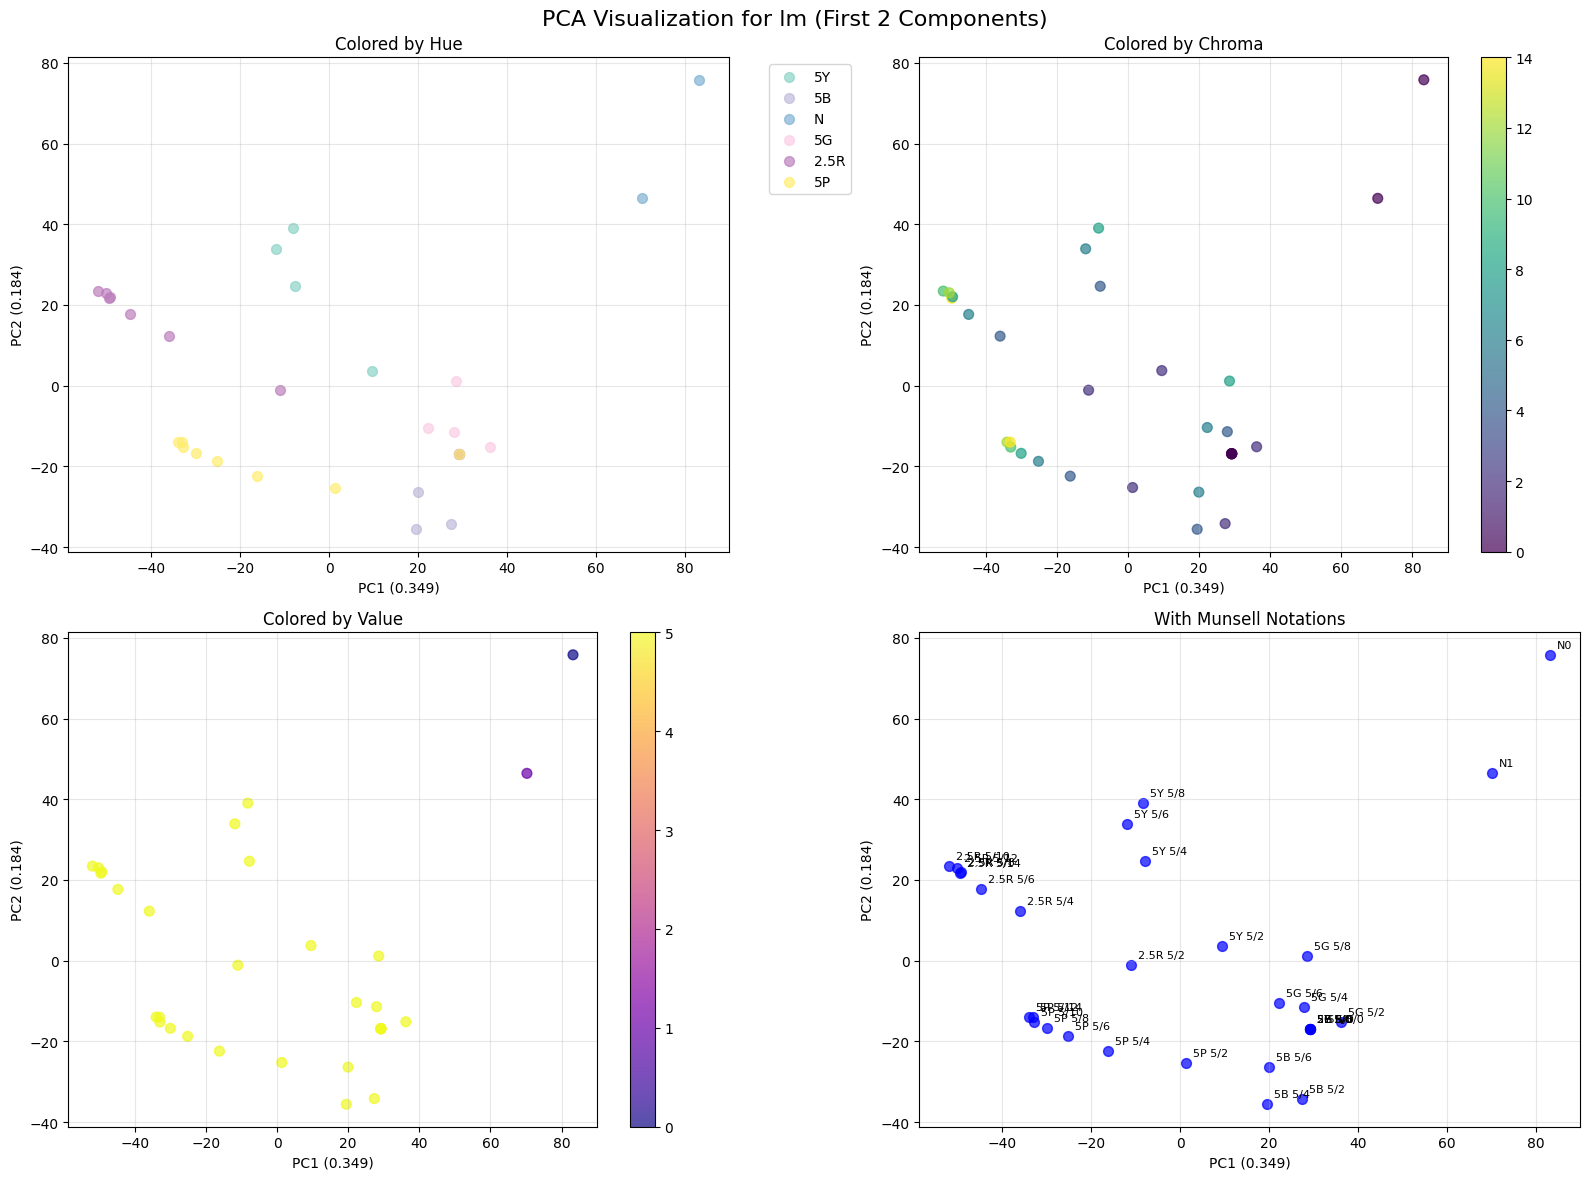

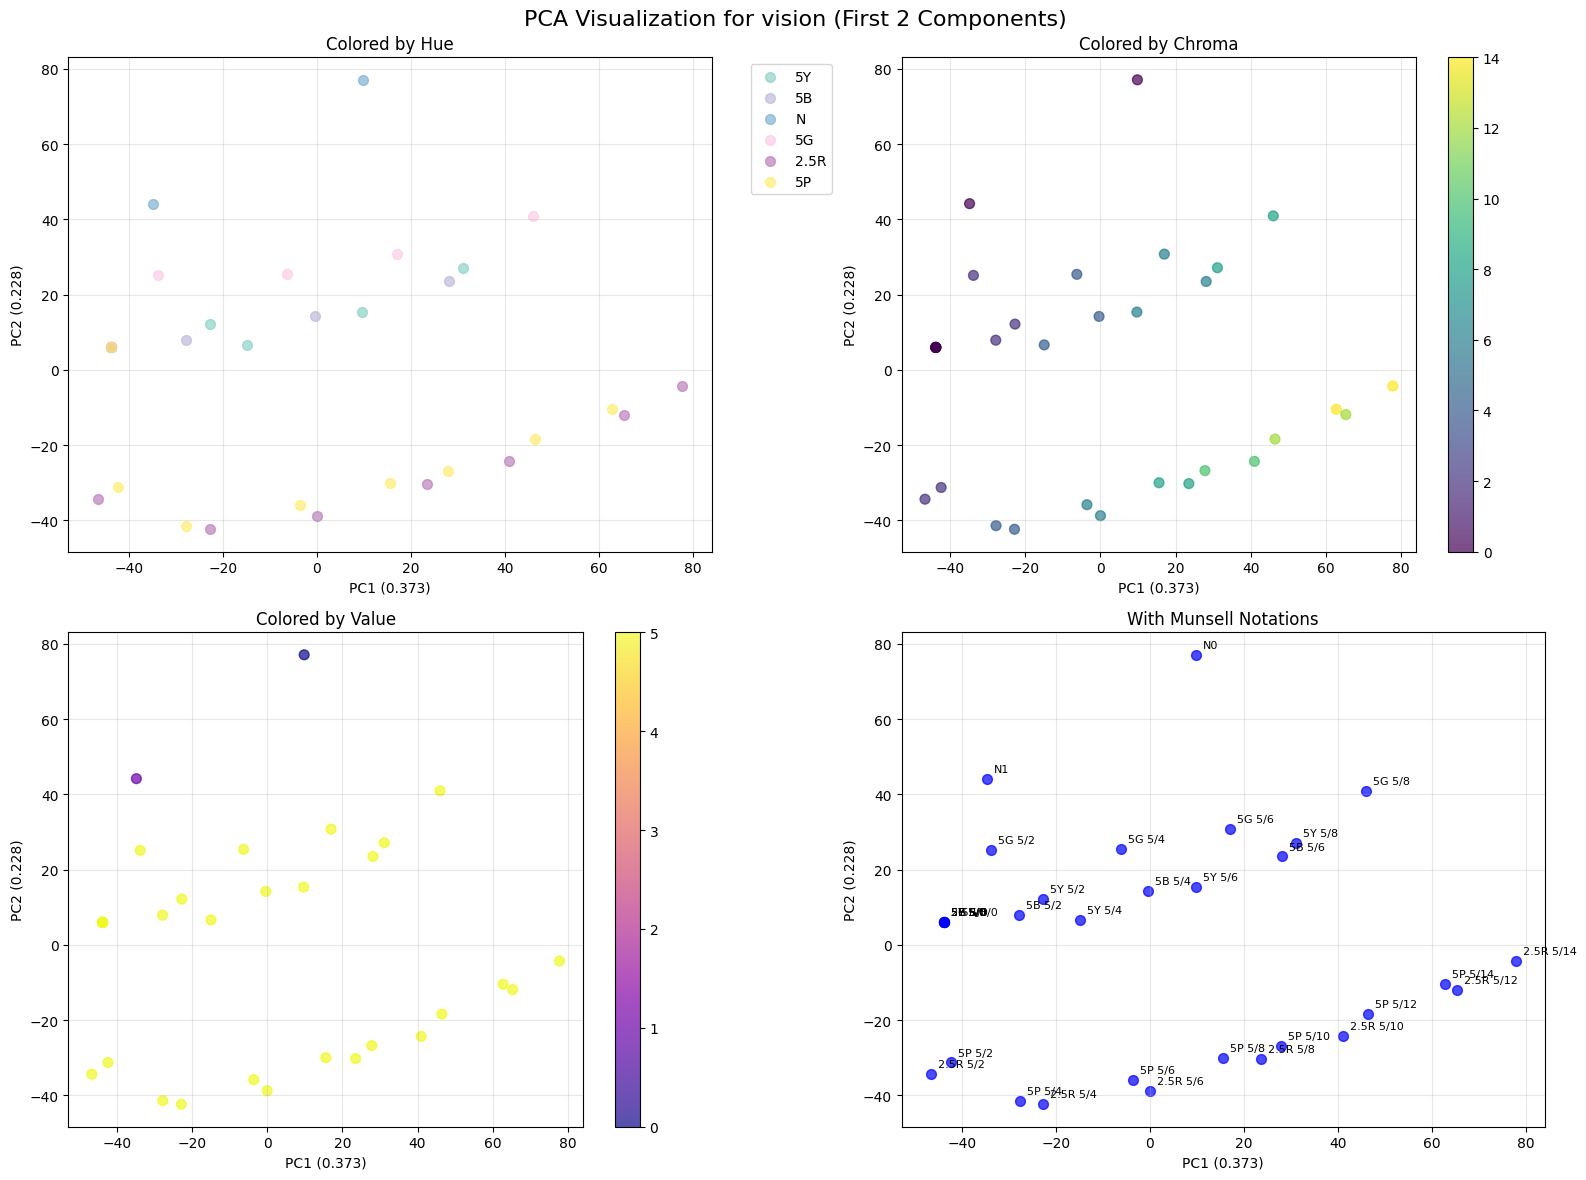

In [16]:
# Visualize PCA results in 2D
def plot_pca_2d(pca_results, color_metadata, embedding_name):
    """Plot first 2 PCA components colored by color attributes"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    pca_result = pca_results[embedding_name]['pca_result']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'PCA Visualization for {embedding_name} (First 2 Components)', fontsize=16)
    
    # Extract color information
    hues = [meta.get('H', 'Unknown') for meta in color_metadata]
    chromas = [meta.get('C', 0) for meta in color_metadata]
    values = [meta.get('V', 0) for meta in color_metadata]
    notations = [meta.get('notation', 'Unknown') for meta in color_metadata]
    
    # Plot 1: Colored by Hue
    unique_hues = list(set(hues))
    hue_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: hue_colors[i] for i, hue in enumerate(unique_hues)}
    
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        axes[0,0].scatter(pca_result[mask, 0], pca_result[mask, 1], 
                         c=[hue_color_map[hue]], label=hue, alpha=0.7, s=50)
    axes[0,0].set_title('Colored by Hue')
    axes[0,0].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[0,0].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Colored by Chroma
    scatter = axes[0,1].scatter(pca_result[:, 0], pca_result[:, 1], 
                               c=chromas, cmap='viridis', alpha=0.7, s=50)
    axes[0,1].set_title('Colored by Chroma')
    axes[0,1].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[0,1].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    plt.colorbar(scatter, ax=axes[0,1])
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Colored by Value
    scatter = axes[1,0].scatter(pca_result[:, 0], pca_result[:, 1], 
                               c=values, cmap='plasma', alpha=0.7, s=50)
    axes[1,0].set_title('Colored by Value')
    axes[1,0].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[1,0].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    plt.colorbar(scatter, ax=axes[1,0])
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: All points with notation labels
    axes[1,1].scatter(pca_result[:, 0], pca_result[:, 1], 
                     c='blue', alpha=0.7, s=50)
    # Add notation labels
    for i, notation in enumerate(notations):
        axes[1,1].annotate(notation, (pca_result[i, 0], pca_result[i, 1]), 
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1,1].set_title('With Munsell Notations')
    axes[1,1].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[1,1].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot PCA 2D results for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        color_meta = {'lm': lm_color_meta, 'vision': vision_color_meta, 'lens': lens_color_meta}[emb_type]
        plot_pca_2d(pca_results, color_meta, emb_type)


In [37]:
# Summary and comparison of results
def print_analysis_summary(pca_results, tsne_results):
    """Print summary of analysis results"""
    print("=" * 80)
    print("EMBEDDING ANALYSIS SUMMARY")
    print("=" * 80)
    
    for emb_type in ['lm', 'vision', 'lens']:
        emb_name = {'lm': 'LM Pooled Mean', 'vision': 'Vision Pooled Mean', 'lens': 'Visual Token Lens'}[emb_type]
        
        print(f"\n{emb_name.upper()}:")
        print("-" * 40)
        
        if emb_type in pca_results and pca_results[emb_type] is not None:
            pca = pca_results[emb_type]
            print(f"PCA Results:")
            print(f"  - Components for 95% variance: {pca['n_components_95']}")
            print(f"  - Components for 99% variance: {pca['n_components_99']}")
            print(f"  - First 2 components explain: {pca['cumulative_variance'][1]:.3f} of variance")
            print(f"  - First 5 components explain: {pca['cumulative_variance'][4]:.3f} of variance")
        else:
            print("  - PCA: No data available")
            
        if emb_type in tsne_results and tsne_results[emb_type] is not None:
            tsne = tsne_results[emb_type]
            print(f"t-SNE Results:")
            print(f"  - Final KL divergence: {tsne['tsne_model'].kl_divergence_:.3f}")
            print(f"  - Perplexity used: {tsne['tsne_model'].perplexity}")
        else:
            print("  - t-SNE: No data available")

print_analysis_summary(pca_results, tsne_results)

# Additional analysis: Compare embedding types
print("\n" + "=" * 80)
print("COMPARATIVE ANALYSIS")
print("=" * 80)

# Compare PCA effectiveness across embedding types
print("\nPCA Effectiveness Comparison:")
print("Embedding Type | 95% Var Components | 99% Var Components | PC1+PC2 Var")
print("-" * 70)

for emb_type in ['lm', 'vision', 'lens']:
    emb_name = {'lm': 'LM Pooled Mean', 'vision': 'Vision Pooled Mean', 'lens': 'Visual Token Lens'}[emb_type]
    if emb_type in pca_results and pca_results[emb_type] is not None:
        pca = pca_results[emb_type]
        pc1_pc2_var = pca['cumulative_variance'][1]
        print(f"{emb_name:15} | {pca['n_components_95']:18} | {pca['n_components_99']:18} | {pc1_pc2_var:.3f}")
    else:
        print(f"{emb_name:15} | {'N/A':18} | {'N/A':18} | N/A")


EMBEDDING ANALYSIS SUMMARY

LM POOLED MEAN:
----------------------------------------
PCA Results:
  - Components for 95% variance: 7
  - Components for 99% variance: 11
  - First 2 components explain: 0.533 of variance
  - First 5 components explain: 0.905 of variance
t-SNE Results:
  - Final KL divergence: 0.122
  - Perplexity used: 7

VISION POOLED MEAN:
----------------------------------------
PCA Results:
  - Components for 95% variance: 7
  - Components for 99% variance: 10
  - First 2 components explain: 0.601 of variance
  - First 5 components explain: 0.913 of variance
t-SNE Results:
  - Final KL divergence: 0.168
  - Perplexity used: 7

VISUAL TOKEN LENS:
----------------------------------------
  - PCA: No data available
  - t-SNE: No data available

COMPARATIVE ANALYSIS

PCA Effectiveness Comparison:
Embedding Type | 95% Var Components | 99% Var Components | PC1+PC2 Var
----------------------------------------------------------------------
LM Pooled Mean  |                  

In [56]:
import scipy
from scipy.stats import pearsonr

# Additional analysis: Chroma progression analysis
def analyze_chroma_progression(pca_results, tsne_results, color_metadata, embedding_name):
    """Analyze how chroma progression is captured in embeddings"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    print(f"\n=== Chroma Progression Analysis for {embedding_name} ===")
    
    # Group by hue and analyze chroma progression
    hue_groups = {}
    for i, meta in enumerate(color_metadata):
        hue = meta.get('H', 'Unknown')
        chroma = meta.get('C', 0)
        if hue not in hue_groups:
            hue_groups[hue] = []
        hue_groups[hue].append((i, chroma, meta.get('notation', 'Unknown')))
    
    # Sort each hue group by chroma
    for hue in hue_groups:
        hue_groups[hue].sort(key=lambda x: x[1])
    
    # Analyze t-SNE progression
    if embedding_name in tsne_results and tsne_results[embedding_name] is not None:
        tsne_result = tsne_results[embedding_name]['tsne_result']
        print("\nt-SNE Chroma Progression:")
        for hue, samples in hue_groups.items():
            if len(samples) > 1:
                indices = [s[0] for s in samples]
                chromas = [s[1] for s in samples]
                tsne_x = tsne_result[indices, 0]
                tsne_y = tsne_result[indices, 1]
                
                # Calculate distance progression
                distances = []
                cosine_distances = []
                chromas_dist = []
                
                # Get the original embeddings for cosine distance calculation
                if embedding_name == 'lm':
                    embeddings = lm_matrix[indices]
                elif embedding_name == 'vision':
                    embeddings = vision_matrix[indices]
                else:
                    embeddings = None
                
                for i in range(len(indices) - 1):
                    # Euclidean distance in t-SNE space
                    dist = np.sqrt((tsne_x[i+1] - tsne_x[i])**2 + (tsne_y[i+1] - tsne_y[i])**2)
                    distances.append(dist)
                    
                    # Cosine distance in original embedding space
                    if embeddings is not None:
                        # Normalize vectors
                        vec_i = embeddings[i] / np.linalg.norm(embeddings[i])
                        vec_j = embeddings[i+1] / np.linalg.norm(embeddings[i+1])
                        # Calculate cosine similarity, then convert to distance
                        cosine_sim = np.dot(vec_i, vec_j)
                        cosine_dist = 1 - cosine_sim  # Convert similarity to distance
                        cosine_distances.append(cosine_dist)
                    
                    chromas_dist.append(chromas[i+1] - chromas[i])
                    
                if len(distances) < 2: continue
                
                print(f"  {hue}: Average step distance = {np.mean(distances):.3f}")
                print(f"    Chroma steps: {chromas_dist}")
                print(f"    Step distances (Euclidean): {distances}")
                print(f"    Variation (Euclidean): {np.std(distances) / np.mean(distances):.3f}")
                
                if cosine_distances:
                    print(f"    Cosine distances: {cosine_distances}")
                    print(f"    Average cosine distance: {np.mean(cosine_distances):.6f}")
                    print(f"    Variation (Cosine): {np.std(cosine_distances) / np.mean(cosine_distances):.3f}")
                    
                    # Calculate correlation between Euclidean and cosine distances
                    if len(distances) > 1 and len(cosine_distances) > 1:
                        correlation = pearsonr(distances, cosine_distances)
                        print(f"    Euclidean vs Cosine correlation: {correlation.statistic:.4f} (p={correlation.pvalue:.4f})")

# Perform chroma progression analysis for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        color_meta = {'lm': lm_color_meta, 'vision': vision_color_meta, 'lens': lens_color_meta}[emb_type]
        analyze_chroma_progression(pca_results, tsne_results, color_meta, emb_type)



=== Chroma Progression Analysis for lm ===

t-SNE Chroma Progression:
  2.5R: Average step distance = 30.999
    Chroma steps: [2, 2, 2, 2, 2, 2, 2]
    Step distances (Euclidean): [np.float32(98.43855), np.float32(26.08503), np.float32(18.121237), np.float32(18.85949), np.float32(18.702738), np.float32(19.530823), np.float32(17.25713)]
    Variation (Euclidean): 0.892
    Cosine distances: [np.float32(0.024610996), np.float32(0.009511471), np.float32(0.0028918982), np.float32(0.0033715963), np.float32(0.0025461912), np.float32(0.002715528), np.float32(0.0017143488)]
    Average cosine distance: 0.006766
    Variation (Cosine): 1.134
    Euclidean vs Cosine correlation: 0.9749 (p=0.0002)
  5Y: Average step distance = 32.810
    Chroma steps: [2, 2, 2, 2]
    Step distances (Euclidean): [np.float32(74.716644), np.float32(23.373463), np.float32(17.084354), np.float32(16.064123)]
    Variation (Euclidean): 0.742
    Cosine distances: [np.float32(0.01499337), np.float32(0.011190057), np.f


=== Step Distance vs Embedding Distance Analysis for lm ===


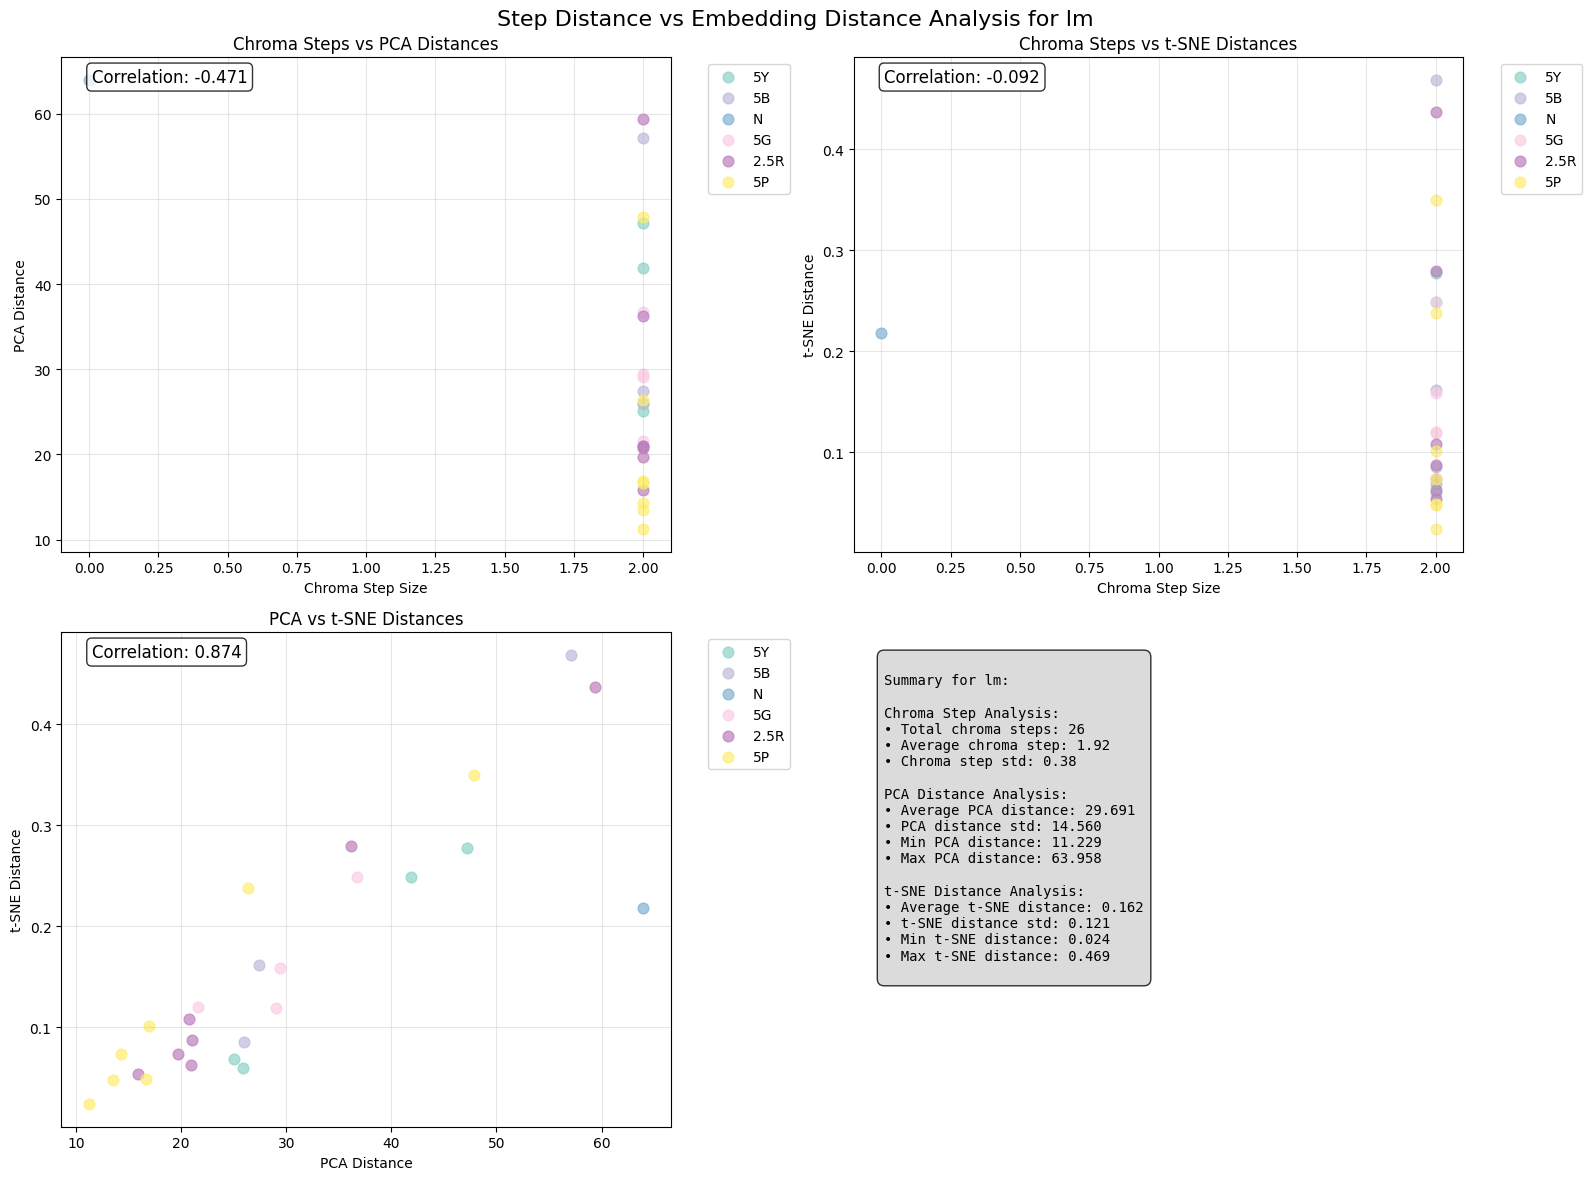


Detailed Correlation Analysis:
Chroma Steps vs PCA Distance: -0.471
Chroma Steps vs t-SNE Distance: -0.092
PCA Distance vs t-SNE Distance: 0.874

=== Step Distance vs Embedding Distance Analysis for vision ===


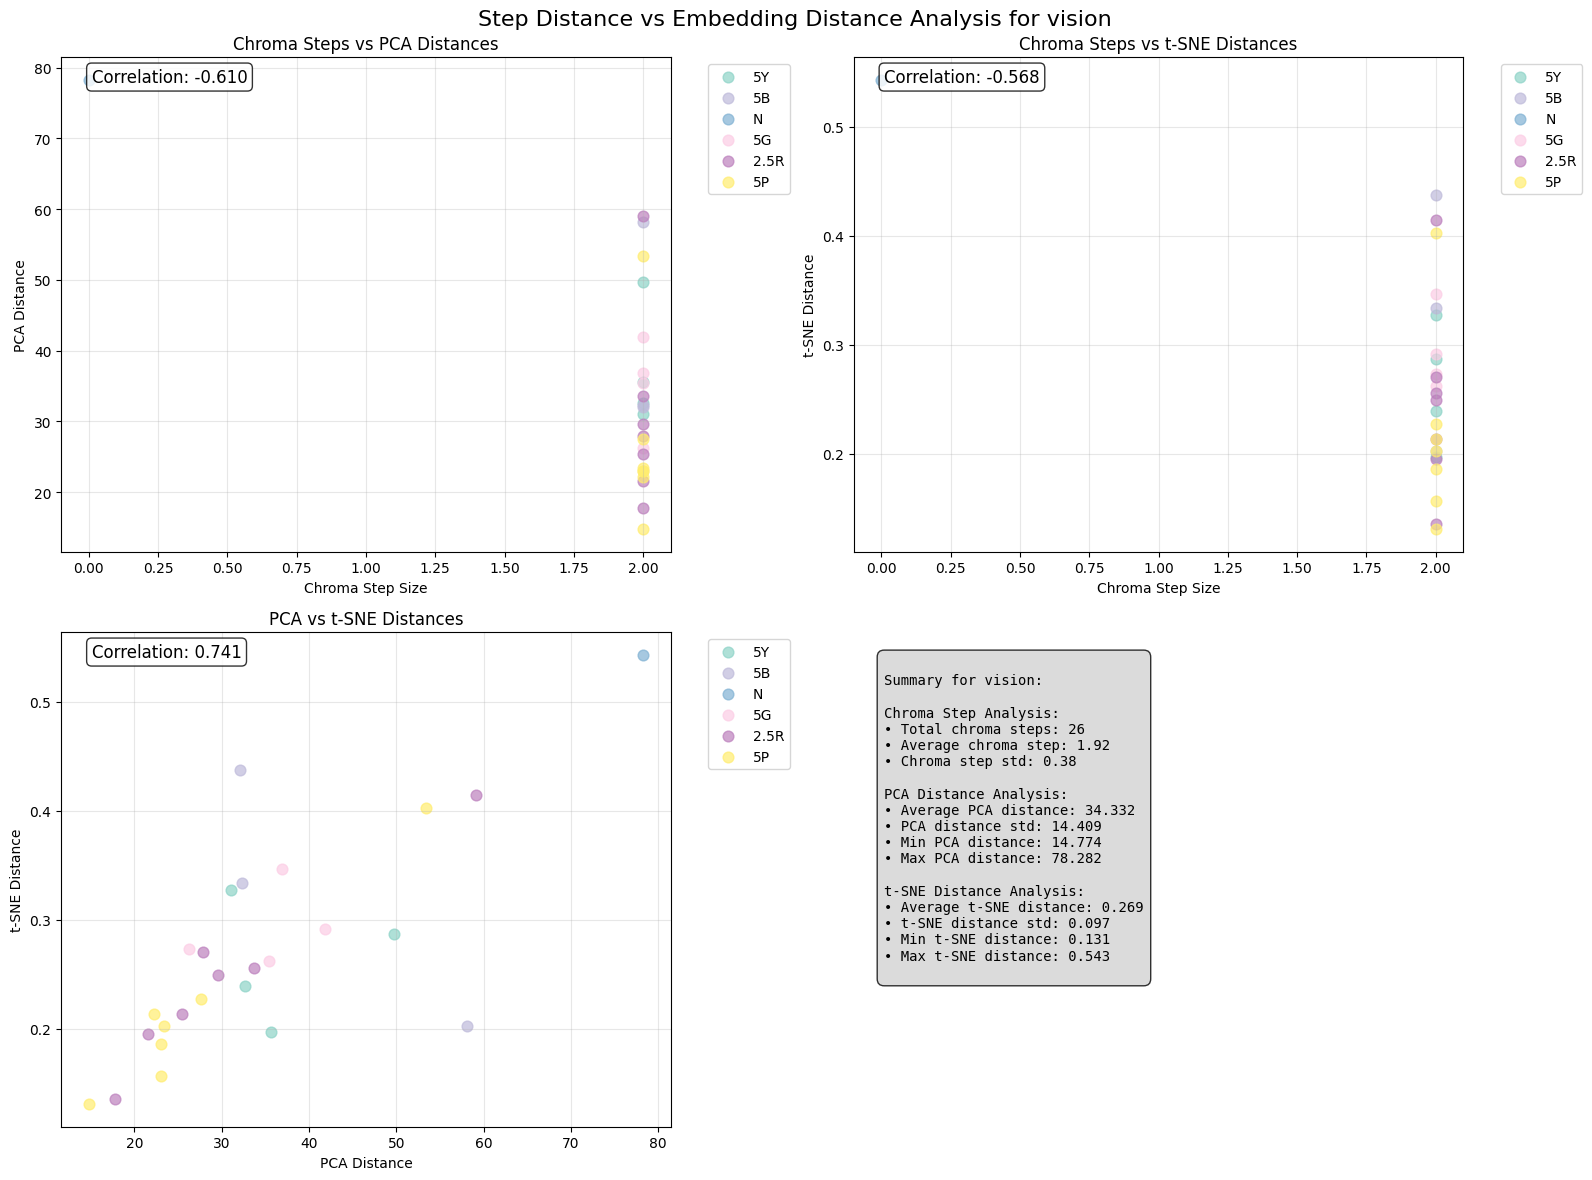


Detailed Correlation Analysis:
Chroma Steps vs PCA Distance: -0.610
Chroma Steps vs t-SNE Distance: -0.568
PCA Distance vs t-SNE Distance: 0.741


In [19]:
# Plot step distance vs PCA/t-SNE distance analysis
def plot_step_vs_embedding_distance(pca_results, tsne_results, color_metadata, embedding_name):
    """Plot step distances (chroma progression) vs PCA/t-SNE distances"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    print(f"\n=== Step Distance vs Embedding Distance Analysis for {embedding_name} ===")
    
    # Group by hue and analyze chroma progression
    hue_groups = {}
    for i, meta in enumerate(color_metadata):
        hue = meta.get('H', 'Unknown')
        chroma = meta.get('C', 0)
        if hue not in hue_groups:
            hue_groups[hue] = []
        hue_groups[hue].append((i, chroma, meta.get('notation', 'Unknown')))
    
    # Sort each hue group by chroma
    for hue in hue_groups:
        hue_groups[hue].sort(key=lambda x: x[1])
    
    # Collect data for plotting
    chroma_steps = []
    pca_distances = []
    tsne_distances = []
    hue_labels = []
    
    pca_result = pca_results[embedding_name]['pca_result']
    tsne_result = tsne_results[embedding_name]['tsne_result'] if embedding_name in tsne_results else None
    
    for hue, samples in hue_groups.items():
        if len(samples) > 1:  # Only analyze hues with multiple chroma levels
            indices = [s[0] for s in samples]
            chromas = [s[1] for s in samples]
            
            # Calculate chroma step sizes
            chroma_steps_hue = []
            for i in range(len(chromas) - 1):
                chroma_steps_hue.append(chromas[i+1] - chromas[i])
            
            # Calculate PCA distances
            pca_distances_hue = []
            for i in range(len(indices) - 1):
                pca_dist = np.linalg.norm(pca_result[indices[i+1]] - pca_result[indices[i]])
                pca_distances_hue.append(pca_dist)
            
            # Calculate t-SNE distances
            tsne_distances_hue = []
            if tsne_result is not None:
                for i in range(len(indices) - 1):
                    tsne_dist = np.linalg.norm(tsne_result[indices[i+1]] - tsne_result[indices[i]])
                    tsne_distances_hue.append(tsne_dist)
            
            # Store data
            chroma_steps.extend(chroma_steps_hue)
            pca_distances.extend(pca_distances_hue)
            if tsne_result is not None:
                tsne_distances.extend(tsne_distances_hue)
            hue_labels.extend([hue] * len(chroma_steps_hue))
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Step Distance vs Embedding Distance Analysis for {embedding_name}', fontsize=16)
    
    # Plot 1: Chroma steps vs PCA distances
    unique_hues = list(set(hue_labels))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: colors[i] for i, hue in enumerate(unique_hues)}
    
    for hue in unique_hues:
        mask = [h == hue for h in hue_labels]
        hue_chroma_steps = [chroma_steps[i] for i, m in enumerate(mask) if m]
        hue_pca_distances = [pca_distances[i] for i, m in enumerate(mask) if m]
        
        axes[0,0].scatter(hue_chroma_steps, hue_pca_distances, 
                         c=[hue_color_map[hue]], label=hue, alpha=0.7, s=60)
    
    axes[0,0].set_xlabel('Chroma Step Size')
    axes[0,0].set_ylabel('PCA Distance')
    axes[0,0].set_title('Chroma Steps vs PCA Distances')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # Calculate and display correlation
    if len(chroma_steps) > 1:
        pca_correlation = np.corrcoef(chroma_steps, pca_distances)[0, 1]
        axes[0,0].text(0.05, 0.95, f'Correlation: {pca_correlation:.3f}', 
                      transform=axes[0,0].transAxes, fontsize=12, 
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Plot 2: Chroma steps vs t-SNE distances
    if tsne_result is not None and len(tsne_distances) > 0:
        for hue in unique_hues:
            mask = [h == hue for h in hue_labels]
            hue_chroma_steps = [chroma_steps[i] for i, m in enumerate(mask) if m]
            hue_tsne_distances = [tsne_distances[i] for i, m in enumerate(mask) if m]
            
            axes[0,1].scatter(hue_chroma_steps, hue_tsne_distances, 
                             c=[hue_color_map[hue]], label=hue, alpha=0.7, s=60)
        
        axes[0,1].set_xlabel('Chroma Step Size')
        axes[0,1].set_ylabel('t-SNE Distance')
        axes[0,1].set_title('Chroma Steps vs t-SNE Distances')
        axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0,1].grid(True, alpha=0.3)
        
        # Calculate and display correlation
        if len(chroma_steps) > 1:
            tsne_correlation = np.corrcoef(chroma_steps, tsne_distances)[0, 1]
            axes[0,1].text(0.05, 0.95, f'Correlation: {tsne_correlation:.3f}', 
                          transform=axes[0,1].transAxes, fontsize=12, 
                          bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    else:
        axes[0,1].text(0.5, 0.5, 'No t-SNE data available', 
                      transform=axes[0,1].transAxes, ha='center', va='center', fontsize=14)
        axes[0,1].set_title('Chroma Steps vs t-SNE Distances')
    
    # Plot 3: PCA vs t-SNE distances
    if tsne_result is not None and len(tsne_distances) > 0:
        for hue in unique_hues:
            mask = [h == hue for h in hue_labels]
            hue_pca_distances = [pca_distances[i] for i, m in enumerate(mask) if m]
            hue_tsne_distances = [tsne_distances[i] for i, m in enumerate(mask) if m]
            
            axes[1,0].scatter(hue_pca_distances, hue_tsne_distances, 
                             c=[hue_color_map[hue]], label=hue, alpha=0.7, s=60)
        
        axes[1,0].set_xlabel('PCA Distance')
        axes[1,0].set_ylabel('t-SNE Distance')
        axes[1,0].set_title('PCA vs t-SNE Distances')
        axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1,0].grid(True, alpha=0.3)
        
        # Calculate and display correlation
        if len(pca_distances) > 1:
            pca_tsne_correlation = np.corrcoef(pca_distances, tsne_distances)[0, 1]
            axes[1,0].text(0.05, 0.95, f'Correlation: {pca_tsne_correlation:.3f}', 
                          transform=axes[1,0].transAxes, fontsize=12, 
                          bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    else:
        axes[1,0].text(0.5, 0.5, 'No t-SNE data available', 
                      transform=axes[1,0].transAxes, ha='center', va='center', fontsize=14)
        axes[1,0].set_title('PCA vs t-SNE Distances')
    
    # Plot 4: Summary statistics
    axes[1,1].axis('off')
    summary_text = f"""
Summary for {embedding_name}:

Chroma Step Analysis:
• Total chroma steps: {len(chroma_steps)}
• Average chroma step: {np.mean(chroma_steps):.2f}
• Chroma step std: {np.std(chroma_steps):.2f}

PCA Distance Analysis:
• Average PCA distance: {np.mean(pca_distances):.3f}
• PCA distance std: {np.std(pca_distances):.3f}
• Min PCA distance: {np.min(pca_distances):.3f}
• Max PCA distance: {np.max(pca_distances):.3f}
"""
    
    if tsne_result is not None and len(tsne_distances) > 0:
        summary_text += f"""
t-SNE Distance Analysis:
• Average t-SNE distance: {np.mean(tsne_distances):.3f}
• t-SNE distance std: {np.std(tsne_distances):.3f}
• Min t-SNE distance: {np.min(tsne_distances):.3f}
• Max t-SNE distance: {np.max(tsne_distances):.3f}
"""
    
    axes[1,1].text(0.05, 0.95, summary_text, transform=axes[1,1].transAxes, 
                  fontsize=10, verticalalignment='top', fontfamily='monospace',
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed correlation analysis
    print(f"\nDetailed Correlation Analysis:")
    if len(chroma_steps) > 1:
        pca_correlation = np.corrcoef(chroma_steps, pca_distances)[0, 1]
        print(f"Chroma Steps vs PCA Distance: {pca_correlation:.3f}")
        
        if tsne_result is not None and len(tsne_distances) > 0:
            tsne_correlation = np.corrcoef(chroma_steps, tsne_distances)[0, 1]
            pca_tsne_correlation = np.corrcoef(pca_distances, tsne_distances)[0, 1]
            print(f"Chroma Steps vs t-SNE Distance: {tsne_correlation:.3f}")
            print(f"PCA Distance vs t-SNE Distance: {pca_tsne_correlation:.3f}")

# Plot step distance analysis for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        color_meta = {'lm': lm_color_meta, 'vision': vision_color_meta, 'lens': lens_color_meta}[emb_type]
        plot_step_vs_embedding_distance(pca_results, tsne_results, color_meta, emb_type)


In [30]:
vector_lm = embeddings_data['lm_pooled_mean'][0]
vector_v = embeddings_data['vision_pooled_mean'][0]

vector_lm /= np.linalg.norm(vector_lm, 2)
vector_v /= np.linalg.norm(vector_v, 2)

print(vector_lm @ vector_v)

0.030704219


In [32]:
vector_v

array([-0.0447949 ,  0.00206865,  0.00407509, ..., -0.0148072 ,
        0.004915  , -0.01816682], shape=(3584,), dtype=float32)

In [31]:
vector_lm

array([0.02879288, 0.02175462, 0.01079733, ..., 0.0003874 , 0.00543866,
       0.00379906], shape=(3584,), dtype=float32)


CROSS-EMBEDDING CORRELATION ANALYSIS (Vision vs LM)


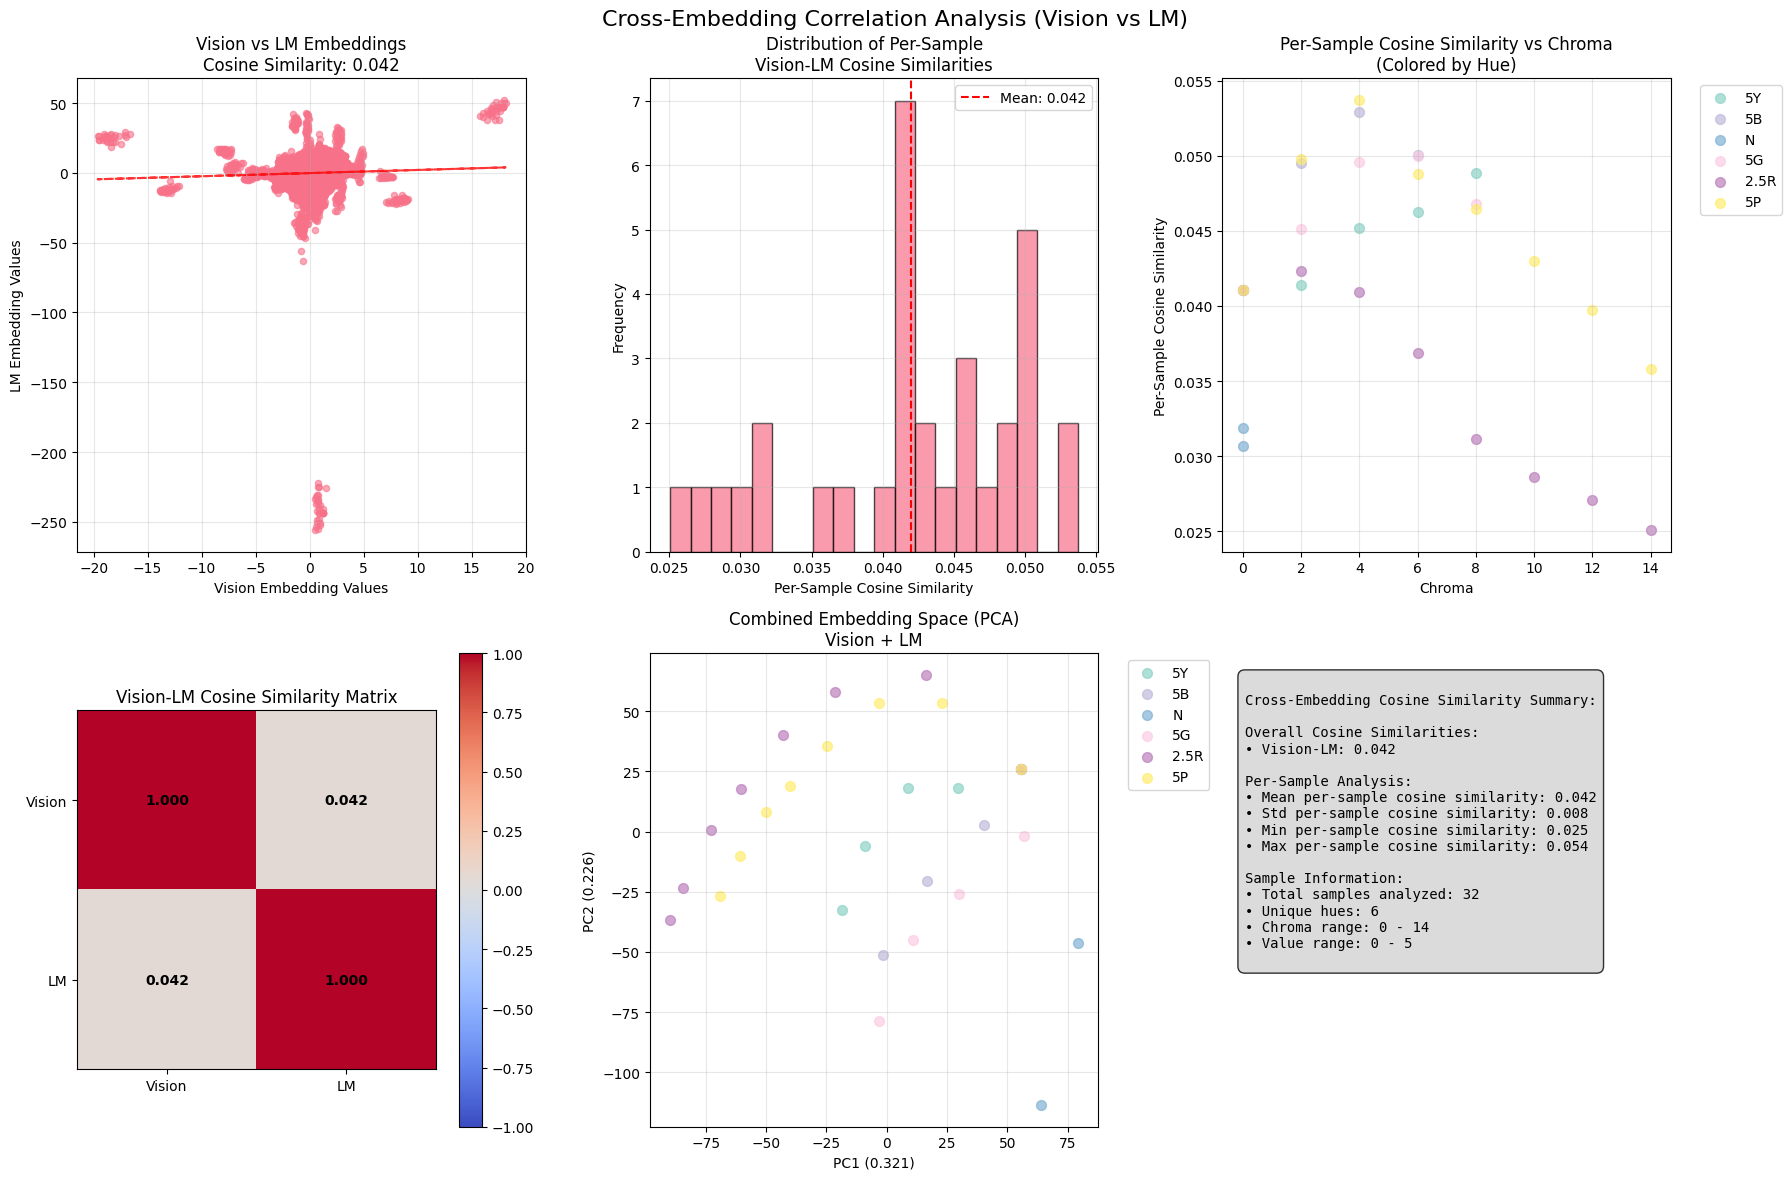


Detailed Cross-Embedding Analysis:
Vision-LM Cosine Similarity: 0.042
Average Cosine Similarity: 0.042

Per-Sample Cosine Similarity Statistics:
  Mean: 0.042
  Std:  0.008
  Min:  0.025
  Max:  0.054

Per-Sample Cosine Similarity by Hue:
  5Y: 0.045 ± 0.003 (n=5)
  5B: 0.048 ± 0.004 (n=4)
  N: 0.031 ± 0.001 (n=2)
  5G: 0.046 ± 0.003 (n=5)
  2.5R: 0.034 ± 0.007 (n=8)
  5P: 0.045 ± 0.006 (n=8)


In [23]:
# Cross-embedding correlation analysis (Vision vs LM only)
def analyze_cross_embedding_correlations(embeddings_data, color_metadata):
    """Analyze correlations between Vision and LM embeddings for the same colors"""
    print("\n" + "=" * 80)
    print("CROSS-EMBEDDING CORRELATION ANALYSIS (Vision vs LM)")
    print("=" * 80)
    
    # Prepare embedding matrices (only Vision and LM)
    lm_matrix, lm_valid_indices = prepare_embedding_matrix(embeddings_data['lm_pooled_mean'])
    vision_matrix, vision_valid_indices = prepare_embedding_matrix(embeddings_data['vision_pooled_mean'])
    
    if lm_matrix is None or vision_matrix is None:
        print("Cannot perform cross-embedding analysis: missing LM or Vision embeddings")
        return
    
    # Find common indices between Vision and LM
    common_indices = set(lm_valid_indices) & set(vision_valid_indices)
    
    if len(common_indices) < 2:
        print("Not enough common samples for correlation analysis")
        return
    
    # Sort common indices to maintain order
    common_indices = sorted(list(common_indices))
    
    # Extract embeddings for common samples
    lm_common = lm_matrix[[lm_valid_indices.index(i) for i in common_indices]]
    vision_common = vision_matrix[[vision_valid_indices.index(i) for i in common_indices]]
    
    # Get color metadata for common samples
    common_color_meta = []
    for i in common_indices:
        idx = embeddings_data['indices'][i]
        if idx in index_to_color:
            common_color_meta.append(index_to_color[idx])
        else:
            common_color_meta.append({'notation': f'Unknown_{idx}', 'H': 'Unknown', 'C': 0, 'V': 0})
    
    # Calculate cosine similarities (cosine of angle between vectors)
    def cosine_similarity(a, b):
        """Calculate cosine similarity between two vectors"""
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    
    correlations = {}
    
    # 1. Overall Vision vs LM cosine similarity (flattened)
    vision_lm_cosine = cosine_similarity(vision_common.flatten(), lm_common.flatten())
    correlations['Vision-LM'] = vision_lm_cosine
    
    # 2. Per-sample cosine similarities (between individual embedding vectors)
    per_sample_cosines = []
    for i in range(len(common_indices)):
        cosine_sim = cosine_similarity(vision_common[i], lm_common[i])
        per_sample_cosines.append(cosine_sim)
    
    # 3. Average cosine similarity across all samples
    avg_cosine_similarity = np.mean(per_sample_cosines)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Cross-Embedding Correlation Analysis (Vision vs LM)', fontsize=16)
    
    # Plot 1: Vision vs LM scatter plot
    axes[0,0].scatter(vision_common.flatten(), lm_common.flatten(), alpha=0.6, s=20)
    axes[0,0].set_xlabel('Vision Embedding Values')
    axes[0,0].set_ylabel('LM Embedding Values')
    axes[0,0].set_title(f'Vision vs LM Embeddings\nCosine Similarity: {vision_lm_cosine:.3f}')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(vision_common.flatten(), lm_common.flatten(), 1)
    p = np.poly1d(z)
    axes[0,0].plot(vision_common.flatten(), p(vision_common.flatten()), "r--", alpha=0.8)
    
    # Plot 2: Per-sample cosine similarity distribution
    axes[0,1].hist(per_sample_cosines, bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(avg_cosine_similarity, color='red', linestyle='--', 
                     label=f'Mean: {avg_cosine_similarity:.3f}')
    axes[0,1].set_xlabel('Per-Sample Cosine Similarity')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Distribution of Per-Sample\nVision-LM Cosine Similarities')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Correlation by color attributes
    hues = [meta.get('H', 'Unknown') for meta in common_color_meta]
    chromas = [meta.get('C', 0) for meta in common_color_meta]
    values = [meta.get('V', 0) for meta in common_color_meta]
    
    # Color by hue
    unique_hues = list(set(hues))
    hue_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: hue_colors[i] for i, hue in enumerate(unique_hues)}
    
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        hue_cosines = [per_sample_cosines[i] for i, m in enumerate(mask) if m]
        hue_chromas = [chromas[i] for i, m in enumerate(mask) if m]
        
        axes[0,2].scatter(hue_chromas, hue_cosines, 
                         c=[hue_color_map[hue]], label=hue, alpha=0.7, s=50)
    
    axes[0,2].set_xlabel('Chroma')
    axes[0,2].set_ylabel('Per-Sample Cosine Similarity')
    axes[0,2].set_title('Per-Sample Cosine Similarity vs Chroma\n(Colored by Hue)')
    axes[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,2].grid(True, alpha=0.3)
    
    # Plot 4: Cosine similarity matrix heatmap (Vision vs LM only)
    cosine_matrix = np.array([
        [1.0, correlations['Vision-LM']],
        [correlations['Vision-LM'], 1.0]
    ])
    
    im = axes[1,0].imshow(cosine_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1,0].set_xticks([0, 1])
    axes[1,0].set_yticks([0, 1])
    axes[1,0].set_xticklabels(['Vision', 'LM'])
    axes[1,0].set_yticklabels(['Vision', 'LM'])
    axes[1,0].set_title('Vision-LM Cosine Similarity Matrix')
    
    # Add cosine similarity values to heatmap
    for i in range(2):
        for j in range(2):
            text = axes[1,0].text(j, i, f'{cosine_matrix[i, j]:.3f}',
                                ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=axes[1,0])
    
    # Plot 5: Embedding space comparison (first 2 PCA components)
    # Apply PCA to combined embeddings (Vision + LM only)
    combined_embeddings = np.hstack([vision_common, lm_common])
    
    pca_combined = PCA(n_components=2)
    pca_result_combined = pca_combined.fit_transform(StandardScaler().fit_transform(combined_embeddings))
    
    # Color by hue
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        axes[1,1].scatter(pca_result_combined[mask, 0], pca_result_combined[mask, 1], 
                         c=[hue_color_map[hue]], label=hue, alpha=0.7, s=50)
    
    axes[1,1].set_xlabel(f'PC1 ({pca_combined.explained_variance_ratio_[0]:.3f})')
    axes[1,1].set_ylabel(f'PC2 ({pca_combined.explained_variance_ratio_[1]:.3f})')
    axes[1,1].set_title('Combined Embedding Space (PCA)\nVision + LM')
    axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1,1].grid(True, alpha=0.3)
    
    # Plot 6: Summary statistics
    axes[1,2].axis('off')
    summary_text = f"""
Cross-Embedding Cosine Similarity Summary:

Overall Cosine Similarities:
• Vision-LM: {correlations['Vision-LM']:.3f}

Per-Sample Analysis:
• Mean per-sample cosine similarity: {avg_cosine_similarity:.3f}
• Std per-sample cosine similarity: {np.std(per_sample_cosines):.3f}
• Min per-sample cosine similarity: {np.min(per_sample_cosines):.3f}
• Max per-sample cosine similarity: {np.max(per_sample_cosines):.3f}

Sample Information:
• Total samples analyzed: {len(common_indices)}
• Unique hues: {len(unique_hues)}
• Chroma range: {min(chromas)} - {max(chromas)}
• Value range: {min(values)} - {max(values)}
"""
    
    axes[1,2].text(0.05, 0.95, summary_text, transform=axes[1,2].transAxes, 
                  fontsize=10, verticalalignment='top', fontfamily='monospace',
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print(f"\nDetailed Cross-Embedding Analysis:")
    print(f"Vision-LM Cosine Similarity: {correlations['Vision-LM']:.3f}")
    print(f"Average Cosine Similarity: {avg_cosine_similarity:.3f}")
    
    print(f"\nPer-Sample Cosine Similarity Statistics:")
    print(f"  Mean: {avg_cosine_similarity:.3f}")
    print(f"  Std:  {np.std(per_sample_cosines):.3f}")
    print(f"  Min:  {np.min(per_sample_cosines):.3f}")
    print(f"  Max:  {np.max(per_sample_cosines):.3f}")
    
    # Analyze by hue
    print(f"\nPer-Sample Cosine Similarity by Hue:")
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        hue_cosines = [per_sample_cosines[i] for i, m in enumerate(mask) if m]
        if len(hue_cosines) > 0:
            print(f"  {hue}: {np.mean(hue_cosines):.3f} ± {np.std(hue_cosines):.3f} (n={len(hue_cosines)})")

# Run the cross-embedding correlation analysis
analyze_cross_embedding_correlations(embeddings_data, index_to_color)


## Analyze embeddings of similar grey color.

In [67]:

# Analysis of Same Colors (C=0, V=5)
# All colors with C=0 and V=5 are the same grey color but with different hues
# We want to analyze the variance and cosine angles of their embeddings

print("=" * 80)
print("SAME COLOR ANALYSIS (C=0, V=5)")
print("=" * 80)

# Identify same color samples (C=0, V=5)
same_color_indices = []
same_color_metadata = []

for i, meta in enumerate(lm_color_meta):
    if meta.get('C') == 0 and meta.get('V') == 5:
        same_color_indices.append(i)
        same_color_metadata.append(meta)
        print(f"Found same color: {meta.get('notation', 'Unknown')} (H={meta.get('H', 'Unknown')})")

print(f"\nTotal same color samples found: {len(same_color_indices)}")

if len(same_color_indices) < 2:
    print("Not enough same color samples for analysis")
else:
    # Extract embeddings for same color samples
    same_color_lm = lm_matrix[same_color_indices]
    same_color_vision = vision_matrix[same_color_indices]
    
    print(same_color_lm[0][1]*1000, same_color_lm[1][1]*1000)
    
    print(f"\nSame color embedding shapes:")
    print(f"  LM embeddings: {same_color_lm.shape}")
    print(f"  Vision embeddings: {same_color_vision.shape}")
    
    # Calculate variance within same color embeddings
    def calculate_embedding_variance(embeddings, embedding_name):
        """Calculate variance statistics for embeddings"""
        print(f"\n=== {embedding_name} Variance Analysis ===")
        
        # Calculate variance across samples (axis=0)
        sample_variance = np.var(same_color_lm, axis=0)
        mean_variance = np.mean(sample_variance)
        std_variance = np.std(sample_variance)
        
        # Calculate pairwise distances between all samples
        pairwise_distances = []
        for i in range(len(same_color_indices)):
            for j in range(i+1, len(same_color_indices)):
                dist = np.linalg.norm(embeddings[i] - embeddings[j])
                pairwise_distances.append(dist)
        
        pairwise_distances = np.array(pairwise_distances)
        
        # Calculate cosine similarities between all samples
        cosine_similarities = []
        for i in range(len(same_color_indices)):
            for j in range(i+1, len(same_color_indices)):
                # Normalize vectors
                vec_i = embeddings[i] / np.linalg.norm(embeddings[i])
                vec_j = embeddings[j] / np.linalg.norm(embeddings[j])
                cosine_sim = np.dot(vec_i, vec_j)
                cosine_similarities.append(cosine_sim)
        
        cosine_similarities = np.array(cosine_similarities)
        
        print(f"Variance Statistics:")
        print(f"  Mean variance across dimensions: {mean_variance:.6f}")
        print(f"  Std variance across dimensions: {std_variance:.6f}")
        print(f"  Min variance: {np.min(sample_variance):.6f}")
        print(f"  Max variance: {np.max(sample_variance):.6f}")
        
        print(f"\nPairwise Distance Statistics:")
        print(f"  Mean pairwise distance: {np.mean(pairwise_distances):.6f}")
        print(f"  Std pairwise distance: {np.std(pairwise_distances):.6f}")
        print(f"  Min pairwise distance: {np.min(pairwise_distances):.6f}")
        print(f"  Max pairwise distance: {np.max(pairwise_distances):.6f}")
        
        print(f"\nCosine Similarity Statistics:")
        print(f"  Mean cosine similarity: {np.mean(cosine_similarities):.6f}")
        print(f"  Std cosine similarity: {np.std(cosine_similarities):.6f}")
        print(f"  Min cosine similarity: {np.min(cosine_similarities):.6f}")
        print(f"  Max cosine similarity: {np.max(cosine_similarities):.6f}")
        
        # Calculate angles in degrees
        angles_degrees = np.arccos(np.clip(cosine_similarities, -1, 1)) * 180 / np.pi
        print(f"\nAngle Statistics (degrees):")
        print(f"  Mean angle: {np.mean(angles_degrees):.2f}°")
        print(f"  Std angle: {np.std(angles_degrees):.2f}°")
        print(f"  Min angle: {np.min(angles_degrees):.2f}°")
        print(f"  Max angle: {np.max(angles_degrees):.2f}°")
        
        return {
            'sample_variance': sample_variance,
            'mean_variance': mean_variance,
            'pairwise_distances': pairwise_distances,
            'cosine_similarities': cosine_similarities,
            'angles_degrees': angles_degrees
        }
    
    # Analyze LM embeddings
    lm_variance_stats = calculate_embedding_variance(same_color_lm, "LM Pooled Mean")
    
    # Analyze Vision embeddings  
    vision_variance_stats = calculate_embedding_variance(same_color_vision, "Vision Pooled Mean")


SAME COLOR ANALYSIS (C=0, V=5)
Found same color: 5Y 5/0 (H=5Y)
Found same color: 5B 5/0 (H=5B)
Found same color: 5G 5/0 (H=5G)
Found same color: 5P 5/0 (H=5P)
Found same color: 2.5R 5/0 (H=2.5R)

Total same color samples found: 5
7187.5 7187.5

Same color embedding shapes:
  LM embeddings: (5, 3584)
  Vision embeddings: (5, 3584)

=== LM Pooled Mean Variance Analysis ===
Variance Statistics:
  Mean variance across dimensions: 0.000000
  Std variance across dimensions: 0.000000
  Min variance: 0.000000
  Max variance: 0.000000

Pairwise Distance Statistics:
  Mean pairwise distance: 0.000000
  Std pairwise distance: 0.000000
  Min pairwise distance: 0.000000
  Max pairwise distance: 0.000000

Cosine Similarity Statistics:
  Mean cosine similarity: 1.000000
  Std cosine similarity: 0.000000
  Min cosine similarity: 1.000000
  Max cosine similarity: 1.000000

Angle Statistics (degrees):
  Mean angle: 0.00°
  Std angle: 0.00°
  Min angle: 0.00°
  Max angle: 0.00°

=== Vision Pooled Mean Va